Moment vs T and general functions

In [2]:
import matplotlib.pyplot as plt

# Set global font sizes
plt.rcParams.update({
    "font.size": 14,        # base font size
    "axes.titlesize": 18,   # title size
    "axes.labelsize": 18,   # x and y labels
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
})

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import scipy.optimize as scop
import csv  
import matplotlib as mpl
#import seaborn as sns
#import Stoner

#THIS BLOCK Sanitises THE DATA AND CONVERTS IT FROM CGS TO SI UNITS IF REQUIRED 


#Filepath where the point the test datafile exists in so it can be accessed
'''MAGNETISATION DATA'''
filepath1 = "C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Magnetisation/"
file1 = "27-01-2025_RUCL3_TB001_0.1T_00002.dat"
FILEANDPATHMag1=filepath1+file1
#MagFC
filepath2 = "C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Magnetisation/"
file2 = "27-01-2025_RUCL3_TB001_0.1T_FC.dat"
FILEANDPATHMag2=filepath2+file2
'''ROTATOR'''
filepath3 = "C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Magnetisation/Rotator/"
file3 = "TB001_RuCl3_H-parra-ab_61p2_mg_14-06-25_ZFCW_1p8K.dat"
FILEANDPATHRotator=filepath3+file3


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as scop
import csv
import matplotlib as mpl

#LOADING FUNCTION
def load_magnetisation_data(file_location, 
                            cgs_or_si="cgs", 
                            temp_range=(0, 300)):
    """
    Load, sanitise, and optionally convert magnetisation data 
    from a PPMS datafile (Quantum Design format).

    Parameters
    ----------
    file_location : str
        Directory where the data file is stored.
    cgs_or_si : str, default "cgs"
        Choose "cgs" to keep raw PPMS units or "si" for SI conversion.
    temp_range : tuple, default (0, 300)
        Lower and upper bounds for temperature filtering (K).

    Returns
    -------
    df : pd.DataFrame
        Sanitised dataframe in chosen units and restricted to the temperature range.
    headers_line : int
        Index where headers started in the original file.
    """
    FILEANDPATH = file_location

    # Find where headers start (due to PPMS metadata junk at top of file)
    index_of_headers = 0
    for i in range(100):
        try:
            _ = pd.read_csv(FILEANDPATH, sep=",", skiprows=i, encoding="unicode_escape")
            index_of_headers = i + 1  # need +1 for correct parsing
            break
        except Exception:
            continue

    # Load dataframe properly
    df_raw = pd.read_csv(FILEANDPATH, sep=",", skiprows=index_of_headers, encoding="unicode_escape")

    # Drop columns with all NaNs
    df_clean = df_raw.dropna(axis=1, how="all")

    # Convert to SI if requested
    if cgs_or_si.lower() == "cgs":
        df_final = df_clean.copy()
    elif cgs_or_si.lower() == "si":
        df_final = df_clean.copy()
        df_final["Magnetic Field (Oe)"] *= 0.0001
        df_final["Moment (emu)"] *= 1e-3
        df_final.rename(columns={
            "Magnetic Field (Oe)": "Magnetic Field (T)",
            "Moment (emu)": "Moment (Am^2)"
        }, inplace=True)
    else:
        raise ValueError("cgs_or_si must be either 'cgs' or 'si'")

    # Apply temperature range filter
    lower_temp, higher_temp = temp_range
    df_final = df_final[(df_final["Temperature (K)"] >= lower_temp) & 
                        (df_final["Temperature (K)"] <= higher_temp)]

    print(f"Headers found at line {index_of_headers}")
    #print(f"Remaining Column Headers: {df_final.columns}")

    return df_final, index_of_headers

#SAVE PLOT FUNCTION
import os
import matplotlib.pyplot as plt

import os
import matplotlib.pyplot as plt

def save_next_plot(folder, prefix="graph", ext="png", fig=None):
    """
    Save the current matplotlib figure into 'folder' with auto-increment filename.
    
    Parameters
    ----------
    folder : str
        Path to the folder where plots will be saved.
    prefix : str, default 'graph'
        Filename prefix, e.g. 'graph' -> graph_001.png
    ext : str, default 'png'
        File extension, e.g. 'png', 'pdf', 'svg'.
    fig : matplotlib.figure.Figure, optional
        Figure to save. Defaults to current figure.
        
    Returns
    -------
    str
        Full path of the saved file.
    """
    os.makedirs(folder, exist_ok=True)
    
    existing = [f for f in os.listdir(folder) if f.startswith(prefix) and f.endswith("." + ext)]
    numbers = []
    for f in existing:
        try:
            num = int(f.replace(prefix + "_", "").replace("." + ext, ""))
            numbers.append(num)
        except ValueError:
            continue
    
    next_num = max(numbers) + 1 if numbers else 1
    filename = f"{prefix}_{next_num:03d}.{ext}"
    fullpath = os.path.join(folder, filename)
    
    if fig is None:
        fig = plt.gcf()
    
    fig.savefig(fullpath, dpi=300, bbox_inches="tight")
    print(f"Plot saved as: {fullpath}")
    
    return fullpath




df_mag1, header_line = load_magnetisation_data(
    file_location=FILEANDPATHMag1,
    cgs_or_si="si",
    temp_range=(2, 100)
)
df_mag2, header_line = load_magnetisation_data(
    file_location=FILEANDPATHMag2,
    cgs_or_si="si",
    temp_range=(2, 100)
)



Headers found at line 30
Headers found at line 30


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure

#THIS BLOCK CONTAINS FUNCTIONS USED FOR PLOTTING 


#function that plots the desired data, x vs y. Can use this function to handle several common plot requests 
def plot_data(df, x_column_title, y_column_title, title):
    x = df.loc[:,x_column_title]
    y = df.loc[:,y_column_title]
    sorted_df = df.sort_values(by=x_column_title)
    #print(sorted_df)
    x_sorted = sorted_df.loc[:,x_column_title]
    y_sorted = sorted_df.loc[:,y_column_title]
    fig = figure(figsize=(18,10))

    plt.scatter(x, y, s=10, 
                #c='r', 
                facecolors='none', edgecolors= 'b', label = 'Data Points')
    #plt.plot(x, y, c='r', linewidth=0.8)
    plt.title(title)
    plt.xlabel(x_column_title)
    plt.ylabel(y_column_title)
    plt.grid('both')
    plt.legend()
    plt.show()


#several other functions to plot the requested two variables!

def plot_mom_vs_temp(df, sample, field, fc_or_zfc):
    #use a try except block to allow the function to deal with data in either form
    for i in [1]:
        try: 
            title =f"Moment(emu) vs Temperature(K) for {sample} at {field}, {fc_or_zfc}"
            plot_data(df, 'Temperature (K)', 'Moment (emu)', title)
        except: 
            title=f"Moment(Am^2) vs Temperature(K) for {sample} at {field}, {fc_or_zfc}"
            plot_data(df,'Temperature (K)', 'Moment (Am^2)', title)

def plot_mom_vs_field(df, sample, field, fc_or_zfc):
    for i in [1]:
        try: 
            title =f"Moment(emu) vs Magnetic Field(Oe) for {sample} at {field}, {fc_or_zfc}"
            plot_data(df, 'Magnetic Field (Oe)','Moment (emu)', title)
        except: 
            title=f"Moment(Am^2) vs Magnetic Field(T) for {sample} at {field}, {fc_or_zfc}"
            plot_data(df, 'Magnetic Field (T)','Moment (Am^2)', title)
    

    '''non completed functions below'''
def plot_rawmag_vs_T(df, sample, field, fc_or_zfc):
    title =f"Raw Magnetisation (emu) vs Temperature (K) for {sample} at {field}, {fc_or_zfc}"
    plot_data(df,'Temperature (K)', 'M. Raw\' (emu)', title)
    


    #work on plotting to beautify them, make them level of a paper, make a separate plot function for pretty plots. make plots readable
    #Take data from additional csv's and overlay them
    #data analysis, use HTE code or plot Low temp behavior 
    #other packages around plotting like seaborn could be good
    #detect anomalies, what do we want from this data.
    #how can this be more flexible?
    #add utility and exercise

ROTATOR

Headers found at line 44


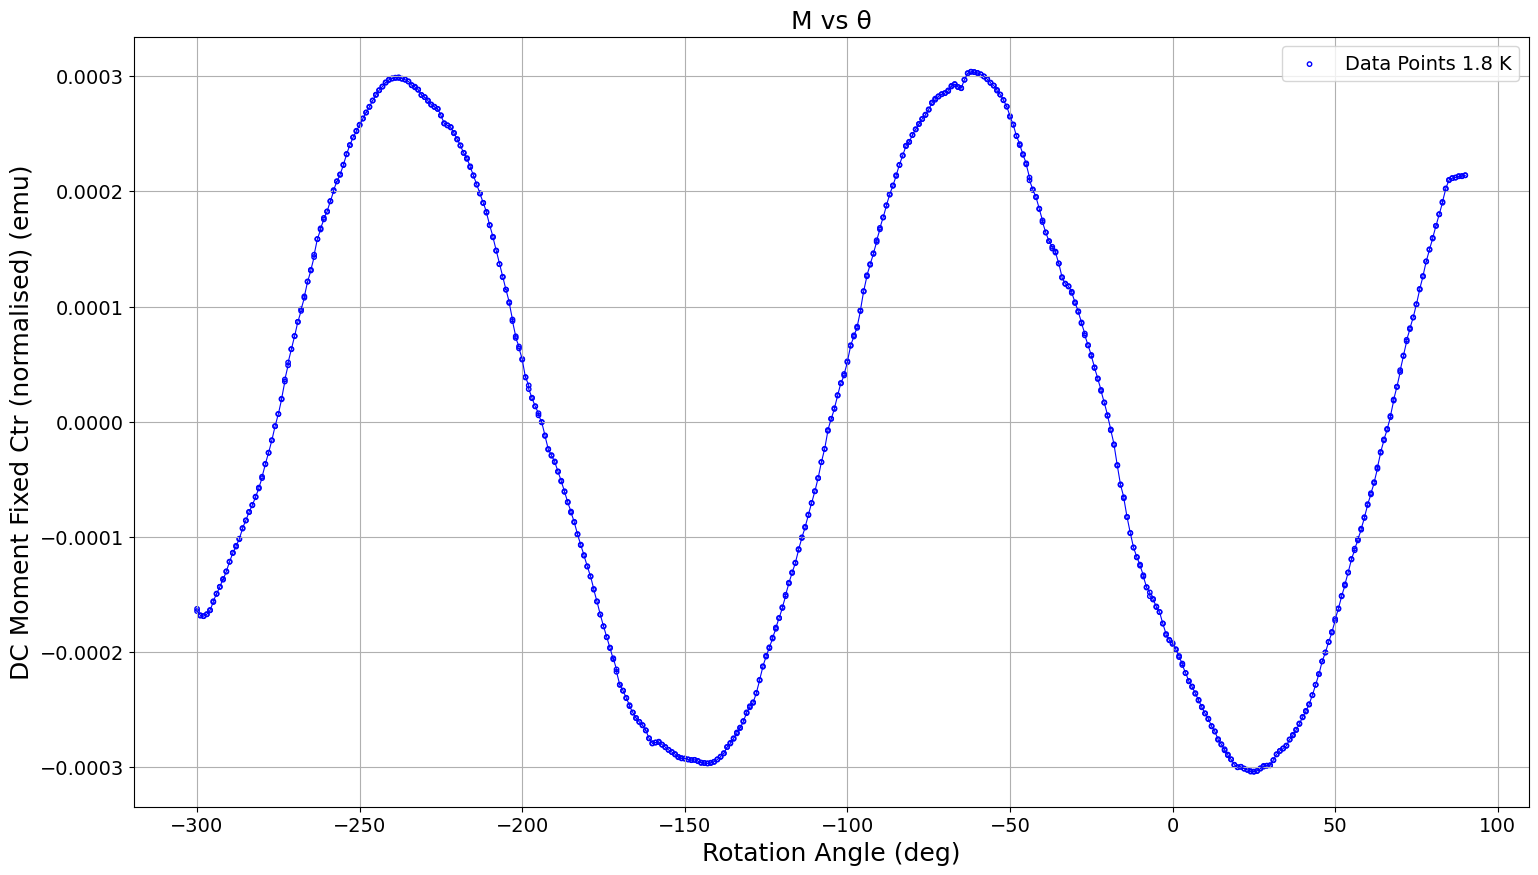

In [22]:
'''ROTATOR'''
filepath = "C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Magnetisation/Rotator/"
df_rotator, index_of_headers = load_magnetisation_data(
    file_location=FILEANDPATHRotator,
    cgs_or_si="cgs",
    temp_range=(2, 100)
)


def plot_data(df, x_column_title, y_column_title, title):
    x = df.loc[:,x_column_title]
    y = df.loc[:,y_column_title]
    sorted_df = df.sort_values(by=x_column_title)
    #print(sorted_df)
    x_sorted = sorted_df.loc[:,x_column_title]
    y_sorted = sorted_df.loc[:,y_column_title]
    fig = figure(figsize=(18,10))

    plt.scatter(x, y, s=10, 
                #c='r', 
                facecolors='none', edgecolors= 'b', label = 'Data Points')
    #plt.plot(x, y, c='r', linewidth=0.8)
    plt.title(title)
    plt.xlabel(x_column_title)
    plt.ylabel(y_column_title)
    plt.grid('both')
    plt.legend()
    plt.show()

def ang_offset(x, offset=300):
    return (x+offset)

def vert_off(y, offset = 0.003):
    return(y+(offset))

#filepath = "C:/Users/thoma/Documents/Physics_Work/Python Scripts/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Magnetisation/Rotator/"
#file = "27-01-2025_RUCL3_TB001_0.1T_00002.dat"

file1 = "TB001_RuCl3_H-parra-ab_61p2_mg_14-06-25_ZFCW_1p8K.dat"
file2 = "TB001_RuCl3_H-parra-ab_61p2_mg_14-06-25_ZFCW_180K.dat"
#C:\Users\thoma\Documents\Physics_Work\Python Scripts\strain-cell\PPMS_Data_and_Plotting\Data\RuCl3\Data\Magnetisation\27-01-2025_RUCL3_TB001_0.1T_00002.dat

FILEANDPATH1=filepath+file1

FILEANDPATH2=filepath+file2

df_raw_data = pandas.read_csv(FILEANDPATH1, sep=",", skiprows= index_of_headers, encoding='unicode_escape')
#df_raw_data['Rotation Angle (deg)'] = df_raw_data['Rotation Angle (deg)']


x = df_raw_data.loc[:,'Rotation Angle (deg)']
x= ang_offset(x,0)
y = df_raw_data.loc[:,'DC Moment Fixed Ctr (emu)']
midrange = (y.max()-y.min())/2
#print(midrange)
offset = -(midrange+y.min())
zero_degree_intercept = -midrange/2

y = vert_off(y, offset)
#sorted_df = df_raw_data.sort_values(by='Rotation Angle (deg)')
sorted_df = df_raw_data
#print(sorted_df)
x_sorted = sorted_df.loc[:,'Rotation Angle (deg)']
y_sorted = sorted_df.loc[:,'DC Moment Fixed Ctr (emu)']

fig = figure(figsize=(18,10))


plt.scatter(x, y, s=10, 
            #c='r', 
                facecolors='none', edgecolors= 'b', label = 'Data Points 1.8 K')
plt.plot(x, y, c='b', linewidth=0.8)


#second plot
df_raw_data = pandas.read_csv(FILEANDPATH2, sep=",", skiprows= index_of_headers, encoding='unicode_escape')
df_raw_data['DC Moment Fixed Ctr (emu)'] = df_raw_data['DC Moment Fixed Ctr (emu)'].apply(vert_off)


x = df_raw_data.loc[:,'Rotation Angle (deg)']
x= ang_offset(x,0)
y = df_raw_data.loc[:,'DC Moment Fixed Ctr (emu)']


#plt.scatter(x, y, s=10, 
            #c='r', 
                #facecolors='none', edgecolors= 'r', label = 'Data Points 180 K')
#plt.plot(x, y, c='r', linewidth=0.8)
#plt.xlim(10,355)

#0 degrees starting line from theroy
#plt.axhline(y=zero_degree_intercept, color='r', linestyle='-')

Title = 'M vs θ'
plt.title(Title)
plt.xlabel('Rotation Angle (deg)')
plt.ylabel('DC Moment Fixed Ctr (normalised) (emu)')
#plt.xlim(0,360)
plt.grid('both')
plt.legend()
#save_next_plot("C:/Users/TXB909/Documents/strain-cell/Plotted Figures", prefix=Title)
#must save plot before plt.show() to ensure it saves the current figure

plt.show()

#plot_data(df_raw_data, 'Rotation Angle (deg)', 'DC Moment Fixed Ctr (emu)', 'M vs θ')




Headers found at line 44
Plot saved as: C:/Users/TXB909/Documents/strain-cell/Plotted Figures\M vs θ Polar_032.png


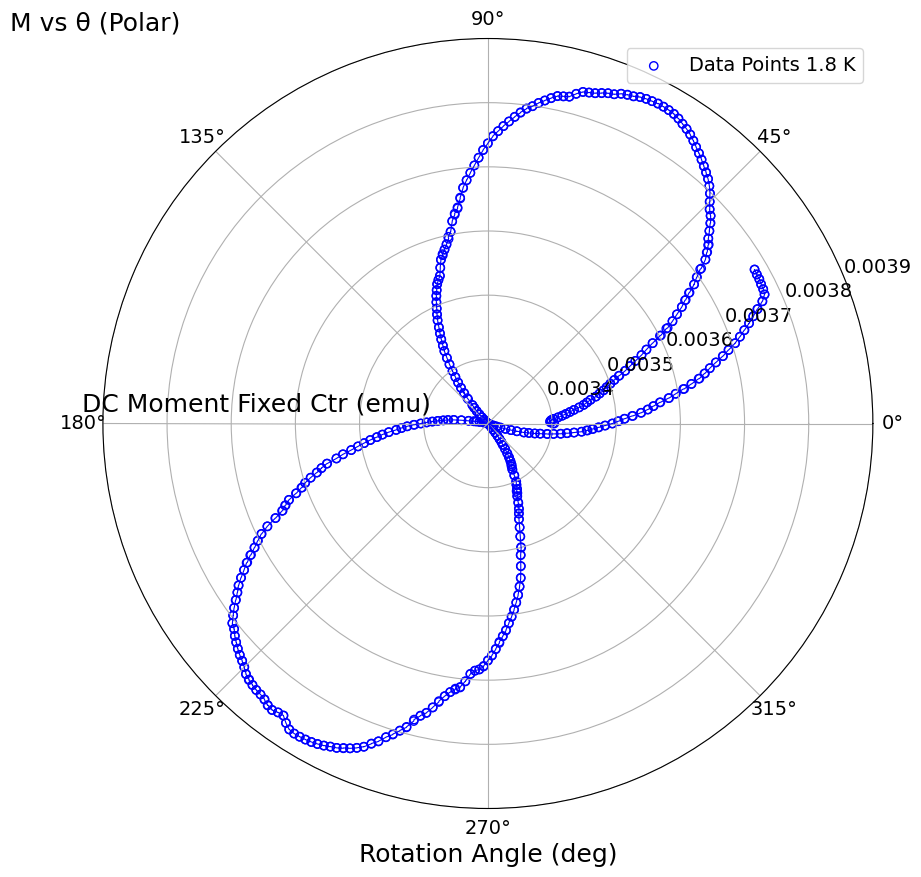

In [6]:
'''ROTATOR'''
filepath = "C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Magnetisation/Rotator/"
df_rotator, index_of_headers = load_magnetisation_data(
    file_location=FILEANDPATHRotator,
    cgs_or_si="cgs",
    temp_range=(2, 100)
)


def plot_data(df, x_column_title, y_column_title, title):
    x = df.loc[:,x_column_title]
    y = df.loc[:,y_column_title]
    sorted_df = df.sort_values(by=x_column_title)
    #print(sorted_df)
    x_sorted = sorted_df.loc[:,x_column_title]
    y_sorted = sorted_df.loc[:,y_column_title]
    fig = figure(figsize=(18,10))

    plt.scatter(x, y, s=10, 
                #c='r', 
                facecolors='none', edgecolors= 'b', label = 'Data Points')
    #plt.plot(x, y, c='r', linewidth=0.8)
    plt.title(title)
    plt.xlabel(x_column_title)
    plt.ylabel(y_column_title)
    plt.grid('both')
    plt.legend()
    plt.show()

def ang_offset(x, offset=300):
    return (x+offset)

def vert_off(y, offset = 0.003):
    return(y+offset)

#filepath = "C:/Users/thoma/Documents/Physics_Work/Python Scripts/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Magnetisation/Rotator/"
#file = "27-01-2025_RUCL3_TB001_0.1T_00002.dat"

file1 = "TB001_RuCl3_H-parra-ab_61p2_mg_14-06-25_ZFCW_1p8K.dat"
file2 = "TB001_RuCl3_H-parra-ab_61p2_mg_14-06-25_ZFCW_180K.dat"
#C:\Users\thoma\Documents\Physics_Work\Python Scripts\strain-cell\PPMS_Data_and_Plotting\Data\RuCl3\Data\Magnetisation\27-01-2025_RUCL3_TB001_0.1T_00002.dat

FILEANDPATH1=filepath+file1

FILEANDPATH2=filepath+file2

# First dataset
df_raw_data = pandas.read_csv(FILEANDPATH1, sep=",", skiprows=index_of_headers, encoding='unicode_escape')
x = df_raw_data.loc[:, 'Rotation Angle (deg)']
x = ang_offset(x)
y = df_raw_data.loc[:, 'DC Moment Fixed Ctr (emu)']

# Convert angles to radians for polar plot
theta = np.deg2rad(x)
r = y

fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection':'polar'})
ax.scatter(theta, r, facecolors='none', edgecolors='b', label='Data Points 1.8 K')
ax.plot(theta, r, c='b', linewidth=0.8)
'''
# Second dataset
df_raw_data = pandas.read_csv(FILEANDPATH2, sep=",", skiprows=index_of_headers, encoding='unicode_escape')
df_raw_data['DC Moment Fixed Ctr (emu)'] = df_raw_data['DC Moment Fixed Ctr (emu)'].apply(vert_off)

x = df_raw_data.loc[:, 'Rotation Angle (deg)']
x = ang_offset(x)
y = df_raw_data.loc[:, 'DC Moment Fixed Ctr (emu)']

theta = np.deg2rad(x)
r = y

ax.scatter(theta, r, facecolors='none', edgecolors='r', label='Data Points 180 K')
ax.plot(theta, r, c='r', linewidth=0.8)
'''


ax.set_title('M vs θ (Polar)')
ax.title.set_position((-0.01, 0))
ax.set_xlabel('Rotation Angle (deg)')
ax.set_ylabel('DC Moment Fixed Ctr (emu)', labelpad=-10, rotation=0)
ax.yaxis.set_label_coords(0.2, 0.51)

ax.set_ylim(0.0033,0.0039)
ax.grid(True)
ax.legend()
save_next_plot("C:/Users/TXB909/Documents/strain-cell/Plotted Figures", prefix='M vs θ Polar')

plt.show()



6.285757575757576
Headers found at line 30
Headers found at line 30


C:\Users\TXB909\AppData\Local\Temp\ipykernel_90860\2394001393.py:92: UserWarning: You passed a edgecolor/edgecolors ('g') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x3, y3, s=10, facecolors='g', edgecolors='g', marker='x', label="FC data 0.1T H//ab")


Plot saved as: C:/Users/TXB909/Documents/strain-cell/Plotted Figures\RuCl3 TB001 magnetic χ FC vs ZFC_023.png


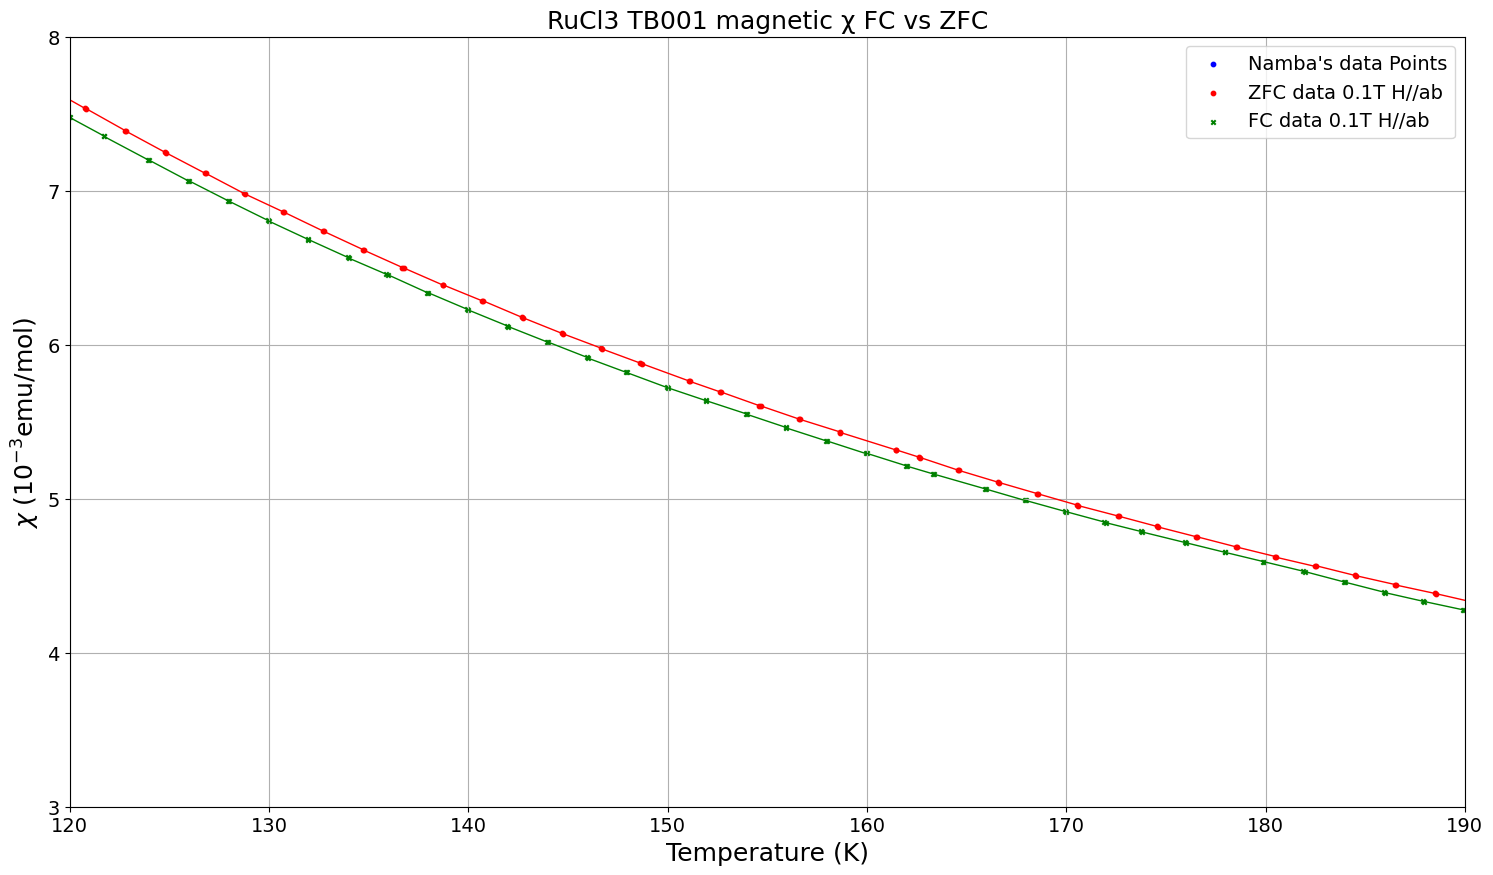

In [7]:
#SUSCEPTIBILITY OF RUCL3
#plot_mom_vs_temp(df_temperature_range, sample, field, fc_or_zfc)


#Namba paperData
#df_ref = pd.read_csv("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/magnetisation/Namba_raw_data.csv", sep=",", encoding='unicode_escape')
df_ref = pd.read_csv("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Magnetisation/Namba_raw_data.csv", sep=",", encoding='unicode_escape')

x = df_ref.loc[:,'x']
y = df_ref.loc[:,' y']
#namba paper data is in emu/mol so to convert ours we must multiply our data by a conversion factor to get the units as emu/mol
x1 = x
y1 = y*1000#to put as 10^-3

#our data
sample_mass=0.033 #in g
molar_mass = 207.43 #in g/mol
field = 1000 #in oe
conversion_factor = molar_mass/(field*sample_mass)
print(conversion_factor)

df_mag1, header_line = load_magnetisation_data(
    file_location=FILEANDPATHMag1,
    cgs_or_si="cgs",
    temp_range=(2, 300)
)
df_magFC, header_line = load_magnetisation_data(
    file_location=FILEANDPATHMag2,
    cgs_or_si="cgs",
    temp_range=(2, 300)
)


x2 = df_mag1.loc[:,'Temperature (K)']
y2 = df_mag1.loc[:,'Moment (emu)']
x2 = x2
y2 = y2*conversion_factor*1000#to put as 10^-3

x3 = df_magFC.loc[:,'Temperature (K)']
y3 = df_magFC.loc[:,'Moment (emu)']
x3 = x3
y3 = y3*conversion_factor*1000#to put as 10^-3

fig = figure(figsize=(18,10))



import numpy as np

def interp_ignore_nans(x, y):
    """Return x_sorted, y_interp with NaNs bridged linearly.
    Works with unsorted x, NaNs, and duplicate x."""
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    # sort by x
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]

    # keep only finite pairs to build the interpolant
    m = np.isfinite(x_sorted) & np.isfinite(y_sorted)
    if m.sum() < 2:
        # not enough points to interpolate; just return sorted inputs
        return x_sorted, y_sorted

    xs = x_sorted[m]
    ys = y_sorted[m]

    # collapse duplicate xs by averaging their y values
    uniq_xs, inv = np.unique(xs, return_inverse=True)
    ys_sum = np.zeros_like(uniq_xs, dtype=float)
    counts = np.zeros_like(uniq_xs, dtype=float)
    np.add.at(ys_sum, inv, ys)
    np.add.at(counts, inv, 1.0)
    ys_mean = ys_sum / counts

    # linear interpolation across the full x range (bridges NaNs)
    y_interp = np.interp(x_sorted, uniq_xs, ys_mean)

    return x_sorted, y_interp


# Build continuous lines
x1s, y1i = interp_ignore_nans(x1, y1)
x2s, y2i = interp_ignore_nans(x2, y2)
x3s, y3i = interp_ignore_nans(x3, y3)

# Plot points
plt.scatter(x1, y1, s=10, facecolors='b', edgecolors='b', label="Namba's data Points")
plt.scatter(x2, y2, s=10, facecolors='r', edgecolors='r', label="ZFC data 0.1T H//ab")
plt.scatter(x3, y3, s=10, facecolors='g', edgecolors='g', marker='x', label="FC data 0.1T H//ab")

# Plot interpolated connecting lines (will continue over NaNs)
plt.plot(x1s, y1i, color='b', linewidth=1)
plt.plot(x2s, y2i, color='r', linewidth=1)
plt.plot(x3s, y3i, color='g', linewidth=1)







plt.xlim(120, 190)
#plt.ylim(bottom = 15)
plt.ylim(3,8)
Title= 'RuCl3 TB001 magnetic χ FC vs ZFC'
plt.title(Title)
#plt.title('RuCl3 Batch TB001 magnetic χ data 05/02/2025')
plt.xlabel('Temperature (K)')
plt.ylabel(r'$\chi$ ($10^{-3}$emu/mol)')
plt.grid('both')
plt.legend()
save_next_plot("C:/Users/TXB909/Documents/strain-cell/Plotted Figures", prefix=Title)
#must save plot before plt.show() to ensure it saves the current figure
plt.show()

plt.close()   # optional: close the figure so the next one starts fresh




Conversion factor: 6.285757575757576
Headers found at line 30
Headers found at line 30
===== Curie–Weiss Fit (ZFC) =====
C      = 0.7391 ± 0.0018 emu·K/mol
μ_eff = 2.431 ± 0.003 μB
θ      = 27.51 ± 0.21 K
χ₀     = -0.000207 ± 0.000005 emu/mol


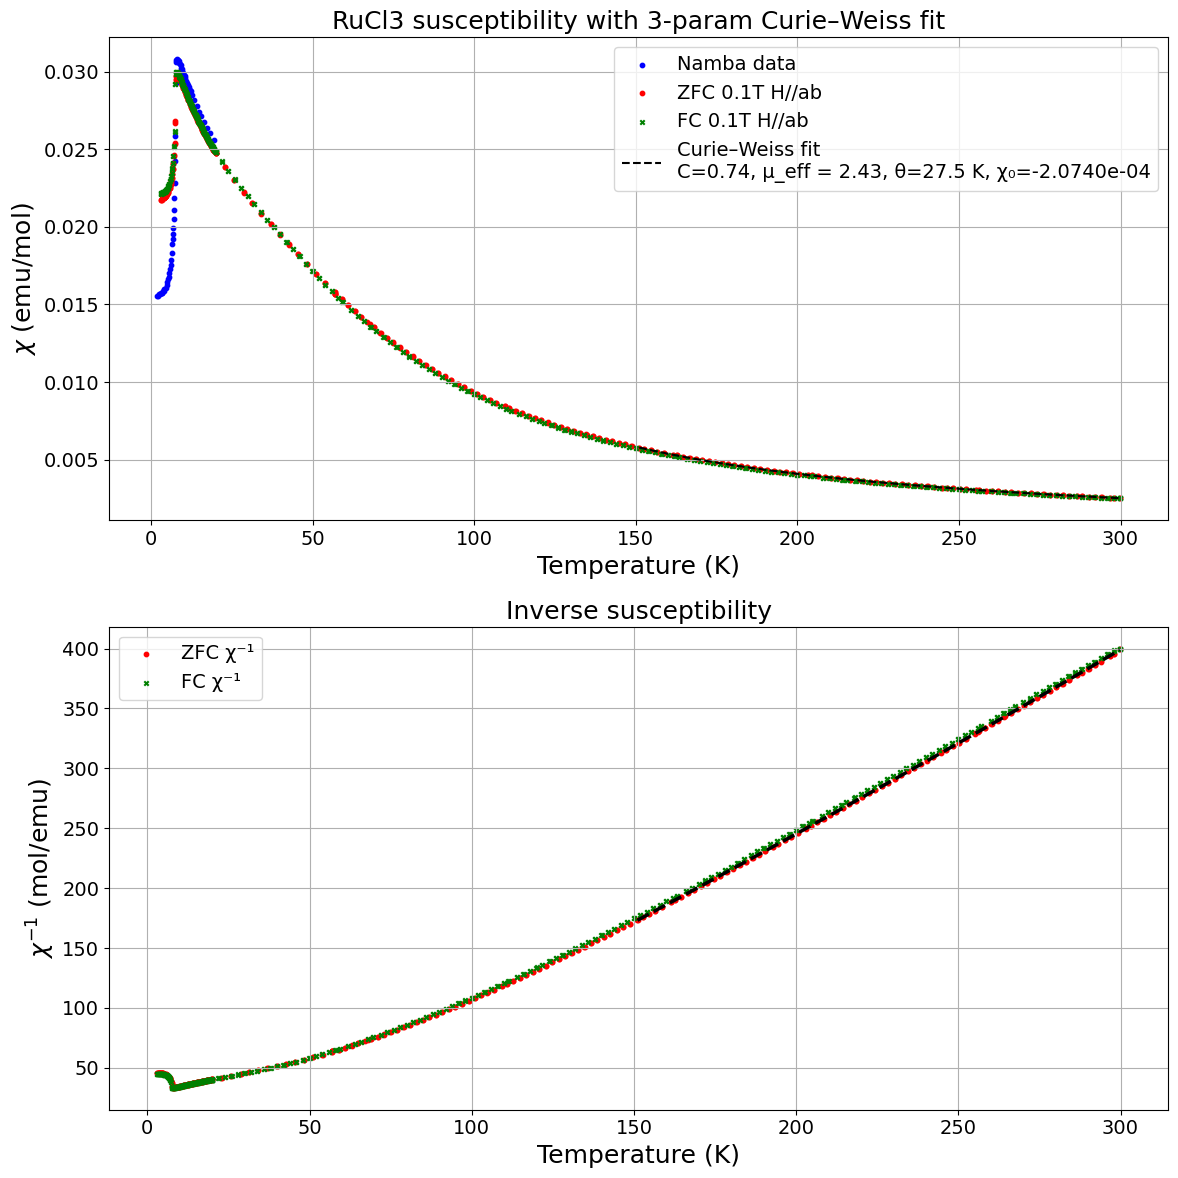

In [8]:
#SUSCEPTIBILITY AND CURIE-WEISS FITTING
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# -----------------------------
# Load reference (Namba) data
# -----------------------------
df_ref = pd.read_csv(
    "C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Magnetisation/Namba_raw_data.csv",
    sep=",", encoding="unicode_escape"
)

x1 = df_ref['x']
y1 = df_ref[' y']   # already emu/mol (not scaled)

# -----------------------------
# Load your data
# -----------------------------
sample_mass = 0.033  # g
molar_mass = 207.43  # g/mol
field = 1000         # Oe
conversion_factor = molar_mass / (field * sample_mass)
print("Conversion factor:", conversion_factor)

df_mag1, header_line = load_magnetisation_data(
    file_location=FILEANDPATHMag1,
    cgs_or_si="cgs",
    temp_range=(2, 300)
)
df_magFC, header_line = load_magnetisation_data(
    file_location=FILEANDPATHMag2,
    cgs_or_si="cgs",
    temp_range=(2, 300)
)

x2 = df_mag1['Temperature (K)']
y2 = df_mag1['Moment (emu)'] * conversion_factor   # χ in emu/mol

x3 = df_magFC['Temperature (K)']
y3 = df_magFC['Moment (emu)'] * conversion_factor  # χ in emu/mol

# -----------------------------
# Define 3-parameter Curie–Weiss
# -----------------------------
def curie_weiss_3param(T, C, theta, chi0):
    return C / (T - theta) + chi0

# -----------------------------
# Fit ZFC curve (example)
# -----------------------------
mask = (x2 > 150) & (x2 < 300)   # fitting window
x_fit = x2[mask]
y_fit = y2[mask]

valid = np.isfinite(x_fit) & np.isfinite(y_fit)
x_fit = x_fit[valid]
y_fit = y_fit[valid]

popt, pcov = curve_fit(curie_weiss_3param, x_fit, y_fit,
                    p0=[0.5, 30, -0.0])  # guesses: C, theta, chi0

C_fit, theta_fit, chi0_fit = popt
perr = np.sqrt(np.diag(pcov))

# assuming C_fit and perr[0] (its 1σ) are from a fit done in emu/mol
# if you used a plotting scale_factor (e.g. 1000), DO NOT apply it here.
C_true = C_fit
dC = perr[0]

mu_eff = 2.828 * np.sqrt(C_true)                 # μB / f.u.
mu_eff_err = 2.828 * 0.5 / np.sqrt(C_true) * dC  # error propagation



print("===== Curie–Weiss Fit (ZFC) =====")
print(f"C      = {C_fit:.4f} ± {perr[0]:.4f} emu·K/mol")
print(f"μ_eff = {mu_eff:.3f} ± {mu_eff_err:.3f} μB")
print(f"θ      = {theta_fit:.2f} ± {perr[1]:.2f} K")
print(f"χ₀     = {chi0_fit:.6f} ± {perr[2]:.6f} emu/mol")

# -----------------------------
# Plot χ(T) with fit
# -----------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# --- χ(T)
ax1.scatter(x1, y1, s=10, color='b', label="Namba data")
ax1.scatter(x2, y2, s=10, color='r', label="ZFC 0.1T H//ab")
ax1.scatter(x3, y3, s=10, color='g', marker='x', label="FC 0.1T H//ab")

T_smooth = np.linspace(min(x_fit), max(x_fit), 500)
ax1.plot(T_smooth, curie_weiss_3param(T_smooth, *popt), 'k--',
        label=f"Curie–Weiss fit\nC={C_fit:.2f}, μ_eff = {mu_eff:.2f}, θ={theta_fit:.1f} K, χ₀={chi0_fit:.4e}")

ax1.set_xlabel("Temperature (K)")
ax1.set_ylabel(r"$\chi$ (emu/mol)")
ax1.set_title("RuCl3 susceptibility with 3-param Curie–Weiss fit")
ax1.grid(True)
ax1.legend()

# --- χ⁻¹(T)
inv_y2 = 1.0 / y2
inv_y3 = 1.0 / y3
ax2.scatter(x2, inv_y2, s=10, color='r', label="ZFC χ⁻¹")
ax2.scatter(x3, inv_y3, s=10, color='g', marker='x', label="FC χ⁻¹")

# For comparison, plot inverse of fit
inv_fit = 1.0 / curie_weiss_3param(T_smooth, *popt)
ax2.plot(T_smooth, inv_fit, 'k--', linewidth=2.5)

ax2.set_xlabel("Temperature (K)")
ax2.set_ylabel(r"$\chi^{-1}$ (mol/emu)")
ax2.set_title("Inverse susceptibility")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


Conversion factor: 6.285757575757576
Headers found at line 30
Headers found at line 30
===== Curie–Weiss Fit (ZFC) =====
C      = 0.7391 ± 0.0018 emu·K/mol
μ_eff = 2.431 ± 0.003 μB
θ      = 27.51 ± 0.21 K
χ₀     = -0.000207 ± 0.000005 emu/mol


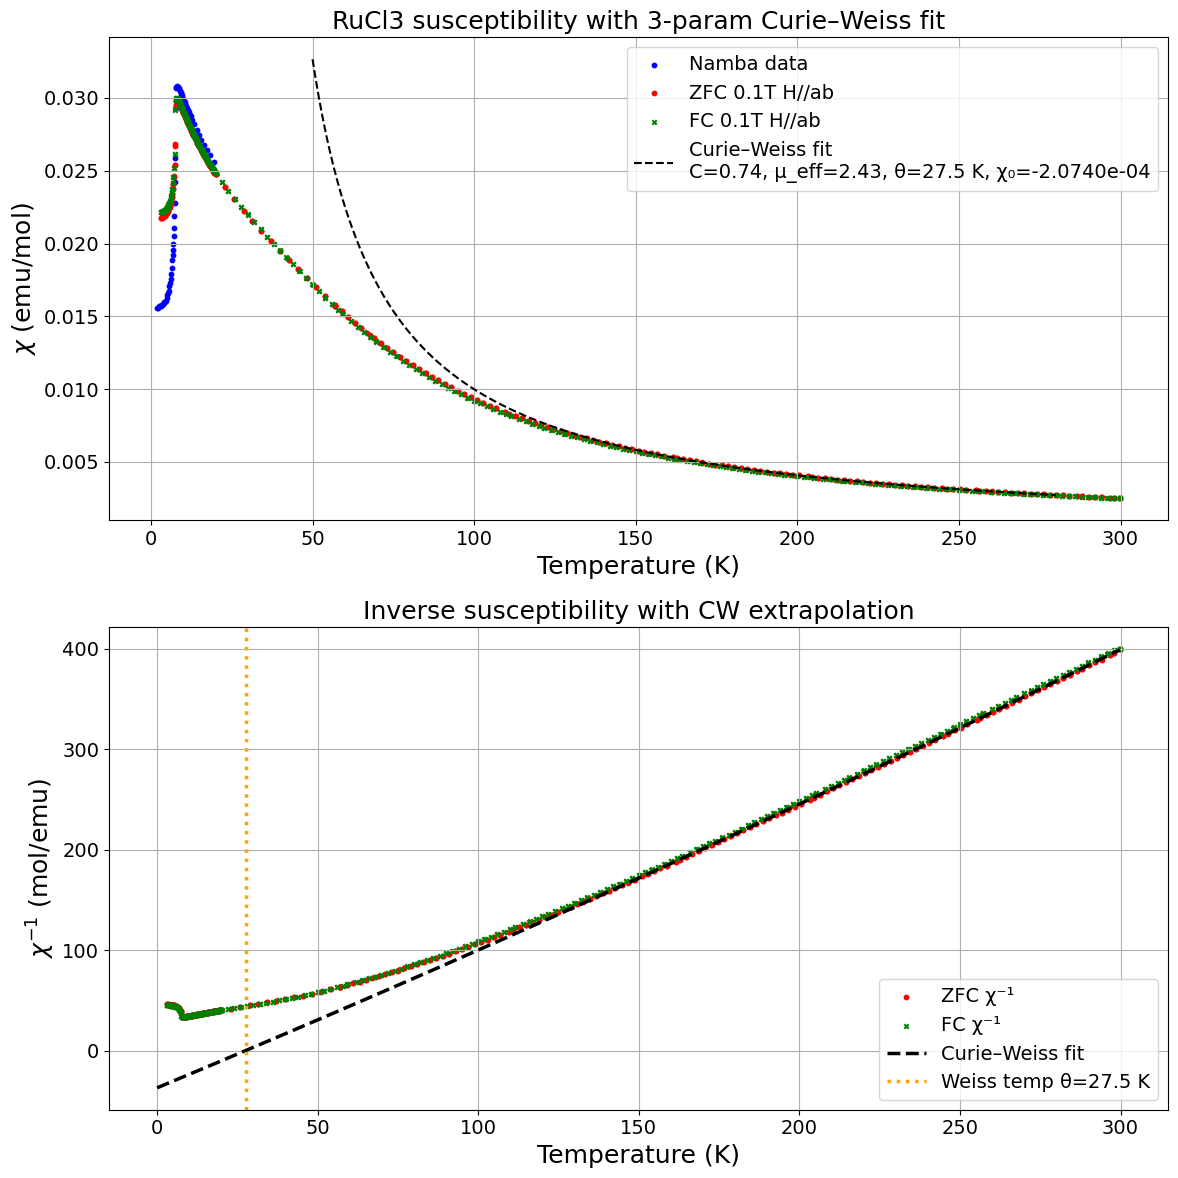

In [9]:
# SUSCEPTIBILITY AND CURIE-WEISS FITTING
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# -----------------------------
# Load reference (Namba) data
# -----------------------------
df_ref = pd.read_csv(
    "C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Magnetisation/Namba_raw_data.csv",
    sep=",", encoding="unicode_escape"
)

x1 = df_ref['x']
y1 = df_ref[' y']  # already emu/mol (not scaled)

# -----------------------------
# Load your data
# -----------------------------
sample_mass = 0.033  # g
molar_mass = 207.43  # g/mol
field = 1000         # Oe
conversion_factor = molar_mass / (field * sample_mass)
print("Conversion factor:", conversion_factor)

df_mag1, header_line = load_magnetisation_data(
    file_location=FILEANDPATHMag1,
    cgs_or_si="cgs",
    temp_range=(2, 300)
)
df_magFC, header_line = load_magnetisation_data(
    file_location=FILEANDPATHMag2,
    cgs_or_si="cgs",
    temp_range=(2, 300)
)

x2 = df_mag1['Temperature (K)']
y2 = df_mag1['Moment (emu)'] * conversion_factor   # χ in emu/mol

x3 = df_magFC['Temperature (K)']
y3 = df_magFC['Moment (emu)'] * conversion_factor  # χ in emu/mol

# -----------------------------
# Define 3-parameter Curie–Weiss
# -----------------------------
def curie_weiss_3param(T, C, theta, chi0):
    return C / (T - theta) + chi0

# -----------------------------
# Fit ZFC curve (example)
# -----------------------------
mask = (x2 > 150) & (x2 < 300)   # fitting window
x_fit = x2[mask]
y_fit = y2[mask]

valid = np.isfinite(x_fit) & np.isfinite(y_fit)
x_fit = x_fit[valid]
y_fit = y_fit[valid]

popt, pcov = curve_fit(curie_weiss_3param, x_fit, y_fit,
                       p0=[0.5, 30, -0.0])  # guesses: C, theta, chi0

C_fit, theta_fit, chi0_fit = popt
perr = np.sqrt(np.diag(pcov))

# Effective moment
C_true = C_fit
dC = perr[0]
mu_eff = 2.828 * np.sqrt(C_true)                 # μB / f.u.
mu_eff_err = 2.828 * 0.5 / np.sqrt(C_true) * dC  # error propagation

print("===== Curie–Weiss Fit (ZFC) =====")
print(f"C      = {C_fit:.4f} ± {perr[0]:.4f} emu·K/mol")
print(f"μ_eff = {mu_eff:.3f} ± {mu_eff_err:.3f} μB")
print(f"θ      = {theta_fit:.2f} ± {perr[1]:.2f} K")
print(f"χ₀     = {chi0_fit:.6f} ± {perr[2]:.6f} emu/mol")

# -----------------------------
# Plot χ(T) with fit
# -----------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# --- χ(T)
ax1.scatter(x1, y1, s=10, color='b', label="Namba data")
ax1.scatter(x2, y2, s=10, color='r', label="ZFC 0.1T H//ab")
ax1.scatter(x3, y3, s=10, color='g', marker='x', label="FC 0.1T H//ab")

# Smooth fit curve over custom plotting range
T_min_plot = 50     # K, lowest temperature to show
T_max_plot = 280   # K, highest temperature to show
T_smooth = np.linspace(T_min_plot, T_max_plot, 1000)
y_fit_curve = curie_weiss_3param(T_smooth, *popt)

# Optional y-clipping to avoid divergence
y_max_plot = 1.5 * np.max(y2)
y_min_plot = -1.0 * np.min(y2)
y_fit_curve_clipped = np.clip(y_fit_curve, y_min_plot, y_max_plot)

ax1.plot(T_smooth, y_fit_curve_clipped, 'k--',
            label=(f"Curie–Weiss fit\n"
                f"C={C_fit:.2f}, μ_eff={mu_eff:.2f}, "
                f"θ={theta_fit:.1f} K, χ₀={chi0_fit:.4e}"))

ax1.set_xlabel("Temperature (K)")
ax1.set_ylabel(r"$\chi$ (emu/mol)")
ax1.set_title("RuCl3 susceptibility with 3-param Curie–Weiss fit")
ax1.grid(True)
ax1.legend()

# --- χ⁻¹(T)
inv_y2 = 1.0 / y2
inv_y3 = 1.0 / y3
ax2.scatter(x2, inv_y2, s=10, color='r', label="ZFC χ⁻¹")
ax2.scatter(x3, inv_y3, s=10, color='g', marker='x', label="FC χ⁻¹")

# Inverse of fit, fully extrapolated to 0 K
T_extrap = np.linspace(0, max(x_fit), 500)
inv_fit = 1.0 / curie_weiss_3param(T_extrap, *popt)
ax2.plot(T_extrap, inv_fit, 'k--', linewidth=2.5, label="Curie–Weiss fit")

# Vertical line at θ
ax2.axvline(theta_fit, color='orange', linestyle=':', linewidth=2.5,
            label=f"Weiss temp θ={theta_fit:.1f} K")

ax2.set_xlabel("Temperature (K)")
ax2.set_ylabel(r"$\chi^{-1}$ (mol/emu)")
ax2.set_title("Inverse susceptibility with CW extrapolation")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


In [10]:
'''OLD CODE BLOCK PRE FUNCTION SANITISATION'''
#FROM HERE AND BELOW THE CODE USES THE NON FUNCTION VERSION OF THE SANITISING SYSTEM

import numpy as np
import matplotlib.pyplot as plt
import pandas
import scipy.optimize as scop
import csv  
import matplotlib as mpl
#import seaborn as sns
#import Stoner

#THIS BLOCK Sanitises THE DATA AND CONVERTS IT FROM CGS TO SI UNITS IF REQUIRED 


#Filepath where the point the test datafile exists in so it can be accessed
'''MAGNETISATION DATA'''
#filepath = "C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Magnetisation/"
#file = "27-01-2025_RUCL3_TB001_0.1T_00002.dat"
#FILEANDPATH=filepath+file
#C:\Users\thoma\Documents\Physics Work\Python Scripts\strain-cell\PPMS_Data_and_Plotting\Data\RuCl3\Data\Magnetisation\27-01-2025_RUCL3_TB001_0.1T_00002.csv

'''ROTATOR'''
filepath = "C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Magnetisation/Rotator/"
file = "TB001_RuCl3_H-parra-ab_61p2_mg_14-06-25_ZFCW_1p8K.dat"
FILEANDPATH=filepath+file

#print(FILEANDPATH)

Labels = ['Time Stamp (sec)', 'Temperature (K)', 'Magnetic Field (Oe)', 'Moment (emu)', 'Chamber Temp (K)', 'Average Temp (K)' ]
#print(FILEANDPATH)


#The filetypes from a PPMS cryostat have a huge amount of non delimeted information at the start, this throws an error when 
#accessed using the csv pandas function so this try and except loop finds the headers as they are in csv format 
index_of_headers = 0
for i in range(100):
    try:
        df_raw_data = pandas.read_csv(FILEANDPATH, sep=",", skiprows=i, encoding='unicode_escape')
        print("headers start on line", i,)
        #make a note of when headers start, need to +1 as we will skip this many rows later and the first one that works is 
        # found not to format the columns correctly
        index_of_headers = int(i+1)
        break
    except:
        None
        #print("headers don't start on line", i,)
    
#print(index_of_headers)

#new dataframe using the index for headers we found
df_raw_data = pandas.read_csv(FILEANDPATH, sep=",", skiprows= index_of_headers, encoding='unicode_escape')


#drop any rows containing all NaN's as these are not useful, we use 'all' not 'any' as most columns have at least 1 NaN
df_sanitised_once_data = df_raw_data.dropna(axis = 1, how = 'all', inplace = False)

''' can sanitise again to make and NaN values the previous using .ffill, can make the graph pretty ugly and wrong, but it does make the lines join up, if you care'''
#df_sanitised_once_data = df_raw_data.ffill()


'''need to have a part here that gets the time stamp column and sets it to 0 each time!'''

#Take information such as if data should be left as cgs or converted to si or if the sample was field cooled or zero field cooled for 
#plotting titles of the graphs
fc_or_zfc = 'zfc'
fc_or_zfc = fc_or_zfc.upper()
cgs_or_si = 'cgs'
field = '0.1T'

# Display the filtered dataframe


start_time = df_sanitised_once_data.loc[0,'Time Stamp (sec)']
#print(start_time)
#print(df_sanitised_once_data['Time Stamp (sec)'])
#df_sanitised_once_data = df_sanitised_once_data['Time Stamp (sec)']-29491894

if cgs_or_si.lower() == "cgs":
    print("CGS, units accepted")
    df_sanitised_cgs =df_sanitised_once_data.copy()
    df_name = df_sanitised_cgs
elif cgs_or_si.lower() == "si":
    print("SI, units accepted")
    
    #create a new df containing the sanitised data in correct units
    df_sanitised_si =df_sanitised_once_data.copy()
    df_sanitised_si['Magnetic Field (Oe)']=df_sanitised_si['Magnetic Field (Oe)']*0.0001
    df_sanitised_si['Moment (emu)']=df_sanitised_si['Moment (emu)']*10**(-3)

    '''More variables can be placed here and then renamed below if used, so far only M-field and Moment have been plotted by me'''

    #rename column names to reflect the new units
    df_sanitised_si.rename(columns ={"Magnetic Field (Oe)": "Magnetic Field (T)", "Moment (emu)":"Moment (Am^2)"}, inplace = True)
    df_name = df_sanitised_si
else: 
    print("Invalid Input. Try again")

print(f"Remaining Column Headers are: {df_name.columns}")

#The below is to put limits on the plots for temperature, comment out if you want the full plot
lower_temp = 0
higher_temp = 300
df_temperature_range = df_name[(df_name['Temperature (K)'] >= lower_temp) & (df_name['Temperature (K)'] <= higher_temp)]


#print(f"{df_raw_data.columns}")

#df_name


headers start on line 43
CGS, units accepted
Remaining Column Headers are: Index(['Time Stamp (sec)', 'Temperature (K)', 'Magnetic Field (Oe)',
       'Transport Action', 'Center Position (mm)', 'Range',
       'Min. Temperature (K)', 'Max. Temperature (K)', 'Min. Field (Oe)',
       'Max. Field (Oe)', 'Pressure (Torr)', 'Measurement Number',
       'SQUID Status (code)', 'Motor Status (code)', 'Measure Status (code)',
       'Motor Current (amps)', 'Motor Temp. (C)', 'Temp. Status (code)',
       'Field Status (code)', 'Chamber Status (code)', 'Chamber Temp (K)',
       'Redirection State', 'Average Temp (K)', 'Rotation Angle (deg)',
       'Rotator state', 'DC Moment Fixed Ctr (emu)',
       'DC Moment Err Fixed Ctr (emu)', 'DC Moment Free Ctr (emu)',
       'DC Moment Err Free Ctr (emu)', 'DC Fixed Fit', 'DC Free Fit',
       'DC Calculated Center (mm)', 'DC Calculated Center Err (mm)',
       'DC Scan Length (mm)', 'DC Scan Time (s)', 'DC Number of Points',
       'DC Squid Drift',

Heat Capacity Plotting


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as scop
import csv
import matplotlib as mpl
#import seaborn as sns
#import Stoner


filepath = "C:/Users/thoma/Documents/Physics_Work/Python Scripts/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/"
#filepath = "C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/"
file = "RuCl3_TB001_HeatCapacity_1.csv"

def HC_PPMS_data_loading(input_filepath):
    
    '''
    function that takes an input file that is a csv and deals with the annoying PPMS header information. can be used to load in multiple csv's via it being a function 
    input_filepath = full filepath of the file desired. in the format of '/' instead of '\'
    
    '''
    #Filepath where the point the test datafile exists in so it can be accessed
    FILEANDPATH=input_filepath
    
    #N.B. Heat capacity uses 'Time Stamp (Seconds)' which is different to regular PPMS data files
    Labels = ['Time Stamp (Seconds)', 'Temperature (K)', 'Magnetic Field (Oe)', 'Moment (emu)', 'Chamber Temp (K)', 'Average Temp (K)', 'Samp HC (J/mole-K)', 'Sample Coupling (Percent)']
    
    #The filetypes from a PPMS cryostat have a huge amount of non delimeted information at the start, this throws an error when 
    #accessed using the csv pandas function so this try and except loop finds the headers as they are in csv format 
    index_of_headers = 0
    for i in range(100):
        try:
            df_raw_data = pd.read_csv(FILEANDPATH, sep=",", skiprows=i, encoding='unicode_escape')
            print("headers start on line", i,)
            #make a note of when headers start, need to +1 as we will skip this many rows later and the first one that works is 
            # found not to format the columns correctly
            index_of_headers = int(i+1)
            break
        except:
            None
            #print("headers don't start on line", i,)
    #new dataframe using the index for headers we found
    df_raw_data = pd.read_csv(FILEANDPATH, sep=",", skiprows= index_of_headers, encoding='unicode_escape')


    #drop any rows containing all NaN's as these are not useful, we use 'all' not 'any' as most columns have at least 1 NaN
    df_name = df_raw_data.dropna(axis = 1, how = 'all', inplace = False)
    #print(f"Remaining Column Headers are: {df_name.columns}")
    return(df_name)




headers start on line 14
headers start on line 12
Plot saved as: C:/Users/TXB909/Documents/strain-cell/Plotted Figures\RuCl3 TB001 H.C._018.png


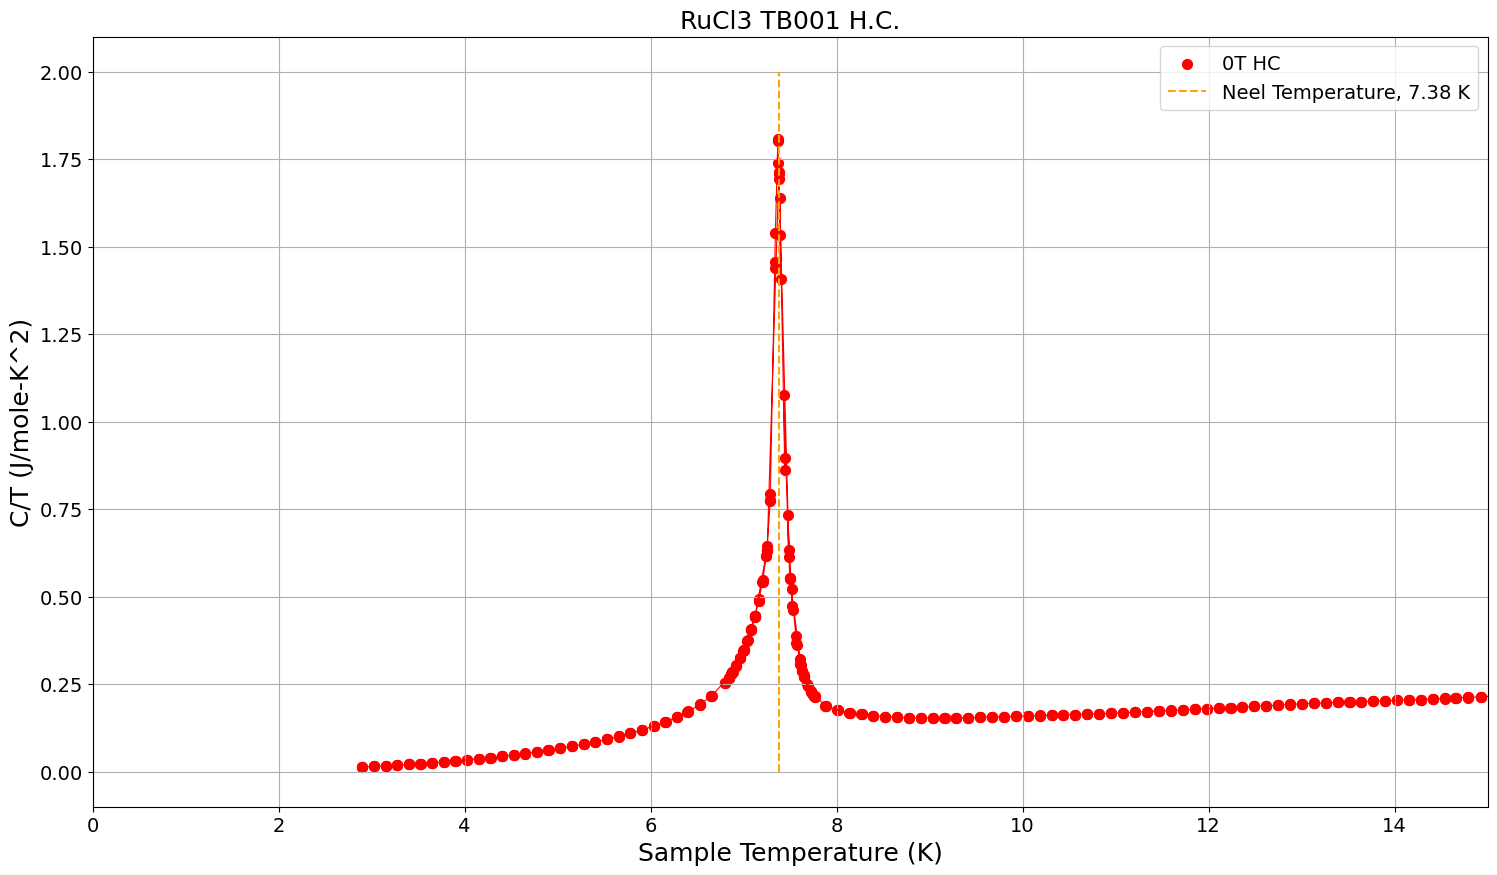

In [12]:
'Samp HC (J/mole-K)'

import pandas as pd
import os

'''
#Namba paperData
df_ref = pd.read_csv("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Namba_data_HC.csv", sep=",", encoding='unicode_escape')
x = df_ref.loc[:,'x']
y = df_ref.loc[:,' y']

x1 = x
y1 = y
'''

#our data

sample_mass=0.033 #in g
molar_mass = 207.43 #in g/mol

#9T HC
'''
HC_9T_RuCl3 = HC_PPMS_data_loading("C:/Users/thoma/Documents/Physics_Work/Python Scripts/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Heat Capacity/RuCl3_TB001_HC_9T_06-04-2025.csv")
#HC_9T_RuCl3 = HC_PPMS_data_loading("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Heat Capacity/RuCl3_TB001_HC_9T_06-04-2025.csv")

x1 = HC_9T_RuCl3.loc[:,'Sample Temp (Kelvin)']
y1 = HC_9T_RuCl3.loc[:,'Samp HC (J/mole-K)']
y1err=HC_9T_RuCl3['Samp HC Err (J/mole-K)']
'''

#0T HC
#HC_0T_RuCl3 = HC_PPMS_data_loading("C:/Users/thoma/Documents/Physics_Work/Python Scripts/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Heat Capacity/RuCl3_TB001_HeatCapacity_1.csv")
HC_0T_RuCl3 = HC_PPMS_data_loading("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Heat Capacity/RuCl3_TB001_HeatCapacity_1.csv")

#OR USE 0T HC Coarse scan
#HC_0T_RuCl3 = HC_PPMS_data_loading("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Heat Capacity/28-03-2025_RuCl3_TB001_0T _001_300-3K.csv")

x2 = HC_0T_RuCl3.loc[:,'Sample Temp (Kelvin)']
y2 = HC_0T_RuCl3.loc[:,'Samp HC (J/mole-K)']
y2err=HC_0T_RuCl3['Samp HC Err (J/mole-K)']

#0T HC later
#HC_0T_RuCl3_2 = HC_PPMS_data_loading("C:/Users/thoma/Documents/Physics_Work/Python Scripts/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Heat Capacity/28-03-2025_RuCl3_TB001_0T _001_300-3K.csv")
HC_0T_RuCl3_2 = HC_PPMS_data_loading("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Heat Capacity/28-03-2025_RuCl3_TB001_0T _001_300-3K.csv")

x3 = HC_0T_RuCl3_2.loc[:,'Sample Temp (Kelvin)']
y3 = HC_0T_RuCl3_2.loc[:,'Samp HC (J/mole-K)']
y3err=HC_0T_RuCl3_2['Samp HC Err (J/mole-K)']



#get Specific heat capacity = C/T

y1 = y1/x1
y2 = y2/x2
y3 = y3/x3
fig = figure(figsize=(18,10))

'''
plt.scatter(x1, y1, s=50, 
                #c='r', 
                facecolors='b', edgecolors= 'b', label = '9T HC')
                
#plt.errorbar(x1, y1, yerr=y1err,capsize=4,                    # little cap on the error bar
    #ecolor='gray',                # color of error bars
    #elinewidth=1.2,
    #markerfacecolor='blue')

plt.plot(x1, y1, c='b', linewidth=0.8)
'''



plt.scatter(x2, y2, marker='o', s=50, 
                #c='r', 
                facecolors='r', edgecolors= 'r', label = '0T HC')

#plt.errorbar(x2, y2, yerr=y2err,capsize=4,                    # little cap on the error bar
#    ecolor='gray',                # color of error bars
#    elinewidth=1.2,
#    markerfacecolor='blue')

plt.plot(x2, y2, c='r', linewidth=0.8)

'''
plt.scatter(x3, y3, marker='o', s=50, 
                #c='r', 
                facecolors='g', edgecolors= 'g', label = '0T HC Taken later')
plt.plot(x3, y3, c='g', linewidth=0.8)
'''

'''
plt.axvline(
    x=7.35,
    color='orange',
    linestyle='--',
    linewidth=1.5,
    label='Neel Temperature, 7.35 K'
)
'''
plt.xlim(0, 15)
plt.vlines(7.38, 0, 2, color='orange', linestyle='--', linewidth=1.5, label='Neel Temperature, 7.38 K')
Title='RuCl3 TB001 H.C.'
plt.title(Title)
plt.xlabel('Sample Temperature (K)')
plt.ylabel('C/T (J/mole-K^2)')
plt.grid('both')
plt.legend()
save_next_plot("C:/Users/TXB909/Documents/strain-cell/Plotted Figures", prefix=Title)
#must save plot before plt.show() to ensure it saves the current figure
plt.show()

6.285757575757576
Headers found at line 30
Headers found at line 30


C:\Users\TXB909\AppData\Local\Temp\ipykernel_90860\3397833889.py:92: UserWarning: You passed a edgecolor/edgecolors ('g') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x3, y3, s=10, facecolors='g', edgecolors='g', marker='x', label="FC data 0.1T H//ab")


Plot saved as: C:/Users/TXB909/Documents/strain-cell/Plotted Figures\RuCl3 TB001 magnetic χ FC vs ZFC_024.png


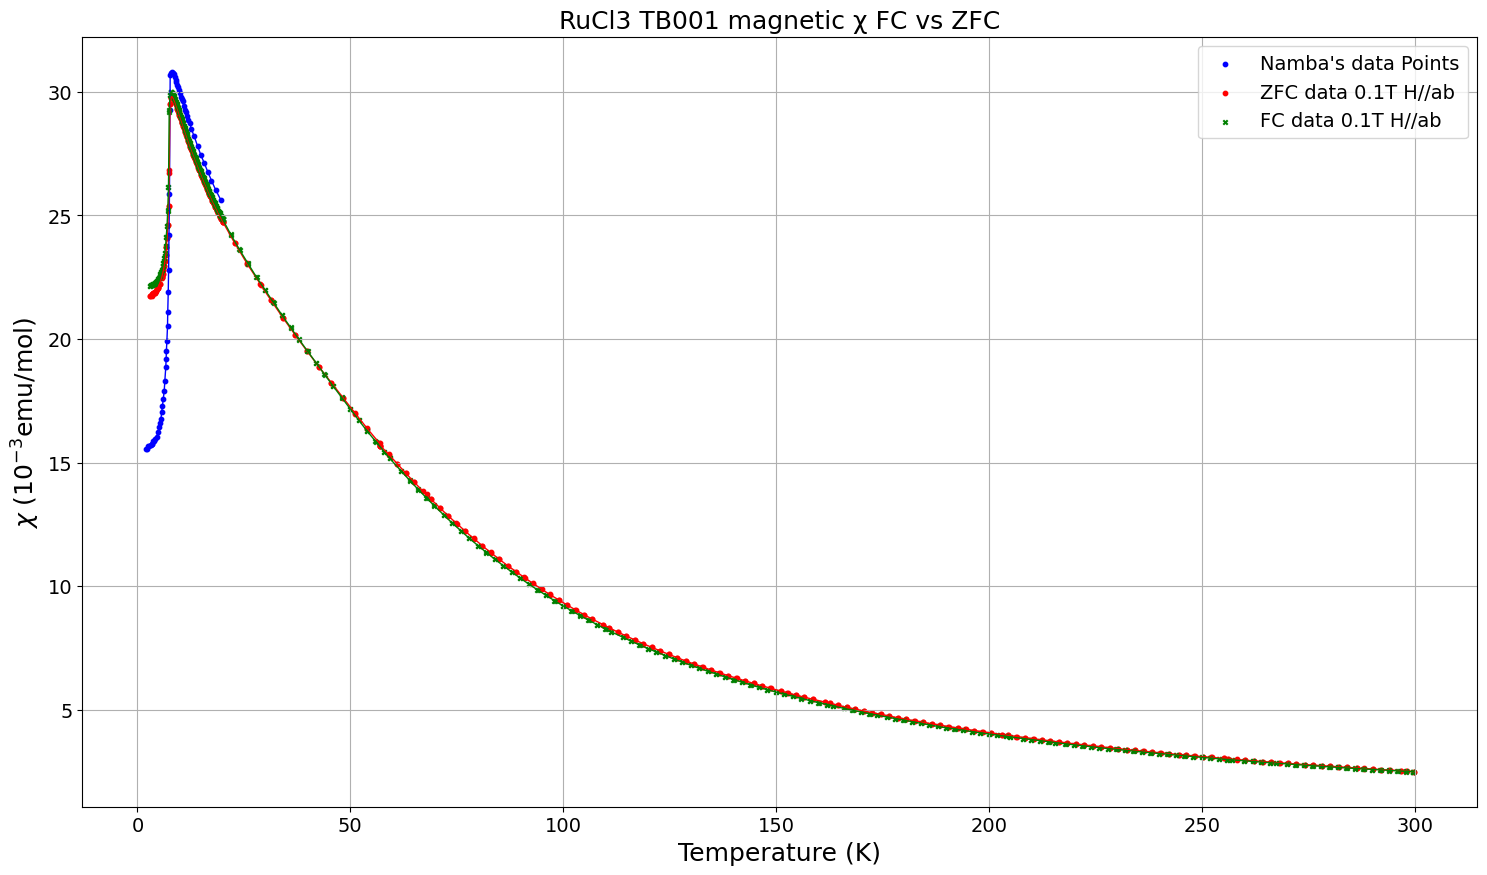

In [13]:
#SUSCEPTIBILITY OF RUCL3
#plot_mom_vs_temp(df_temperature_range, sample, field, fc_or_zfc)


#Namba paperData
#df_ref = pd.read_csv("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/magnetisation/Namba_raw_data.csv", sep=",", encoding='unicode_escape')
df_ref = pd.read_csv("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Magnetisation/Namba_raw_data.csv", sep=",", encoding='unicode_escape')

x = df_ref.loc[:,'x']
y = df_ref.loc[:,' y']
#namba paper data is in emu/mol so to convert ours we must multiply our data by a conversion factor to get the units as emu/mol
x1 = x
y1 = y*1000#to put as 10^-3

#our data
sample_mass=0.033 #in g
molar_mass = 207.43 #in g/mol
field = 1000 #in oe
conversion_factor = molar_mass/(field*sample_mass)
print(conversion_factor)

df_mag1, header_line = load_magnetisation_data(
    file_location=FILEANDPATHMag1,
    cgs_or_si="cgs",
    temp_range=(2, 300)
)
df_magFC, header_line = load_magnetisation_data(
    file_location=FILEANDPATHMag2,
    cgs_or_si="cgs",
    temp_range=(2, 300)
)


x2 = df_mag1.loc[:,'Temperature (K)']
y2 = df_mag1.loc[:,'Moment (emu)']
x2 = x2
y2 = y2*conversion_factor*1000#to put as 10^-3

x3 = df_magFC.loc[:,'Temperature (K)']
y3 = df_magFC.loc[:,'Moment (emu)']
x3 = x3
y3 = y3*conversion_factor*1000#to put as 10^-3

fig = figure(figsize=(18,10))



import numpy as np

def interp_ignore_nans(x, y):
    """Return x_sorted, y_interp with NaNs bridged linearly.
    Works with unsorted x, NaNs, and duplicate x."""
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    # sort by x
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]

    # keep only finite pairs to build the interpolant
    m = np.isfinite(x_sorted) & np.isfinite(y_sorted)
    if m.sum() < 2:
        # not enough points to interpolate; just return sorted inputs
        return x_sorted, y_sorted

    xs = x_sorted[m]
    ys = y_sorted[m]

    # collapse duplicate xs by averaging their y values
    uniq_xs, inv = np.unique(xs, return_inverse=True)
    ys_sum = np.zeros_like(uniq_xs, dtype=float)
    counts = np.zeros_like(uniq_xs, dtype=float)
    np.add.at(ys_sum, inv, ys)
    np.add.at(counts, inv, 1.0)
    ys_mean = ys_sum / counts

    # linear interpolation across the full x range (bridges NaNs)
    y_interp = np.interp(x_sorted, uniq_xs, ys_mean)

    return x_sorted, y_interp


# Build continuous lines
x1s, y1i = interp_ignore_nans(x1, y1)
x2s, y2i = interp_ignore_nans(x2, y2)
x3s, y3i = interp_ignore_nans(x3, y3)

# Plot points
plt.scatter(x1, y1, s=10, facecolors='b', edgecolors='b', label="Namba's data Points")
plt.scatter(x2, y2, s=10, facecolors='r', edgecolors='r', label="ZFC data 0.1T H//ab")
plt.scatter(x3, y3, s=10, facecolors='g', edgecolors='g', marker='x', label="FC data 0.1T H//ab")

# Plot interpolated connecting lines (will continue over NaNs)
plt.plot(x1s, y1i, color='b', linewidth=1)
plt.plot(x2s, y2i, color='r', linewidth=1)
plt.plot(x3s, y3i, color='g', linewidth=1)







#plt.xlim(0, 20)
#plt.ylim(bottom = 15)
#plt.ylim(3,8)
Title= 'RuCl3 TB001 magnetic χ FC vs ZFC'
plt.title(Title)
#plt.title('RuCl3 Batch TB001 magnetic χ data 05/02/2025')
plt.xlabel('Temperature (K)')
plt.ylabel(r'$\chi$ ($10^{-3}$emu/mol)')
plt.grid('both')
plt.legend()
save_next_plot("C:/Users/TXB909/Documents/strain-cell/Plotted Figures", prefix=Title)
#must save plot before plt.show() to ensure it saves the current figure
plt.show()

plt.close()   # optional: close the figure so the next one starts fresh




6.285757575757576
Headers found at line 30
Headers found at line 30


C:\Users\TXB909\AppData\Local\Temp\ipykernel_90860\3397833889.py:92: UserWarning: You passed a edgecolor/edgecolors ('g') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x3, y3, s=10, facecolors='g', edgecolors='g', marker='x', label="FC data 0.1T H//ab")


Plot saved as: C:/Users/TXB909/Documents/strain-cell/Plotted Figures\RuCl3 TB001 magnetic χ FC vs ZFC_025.png


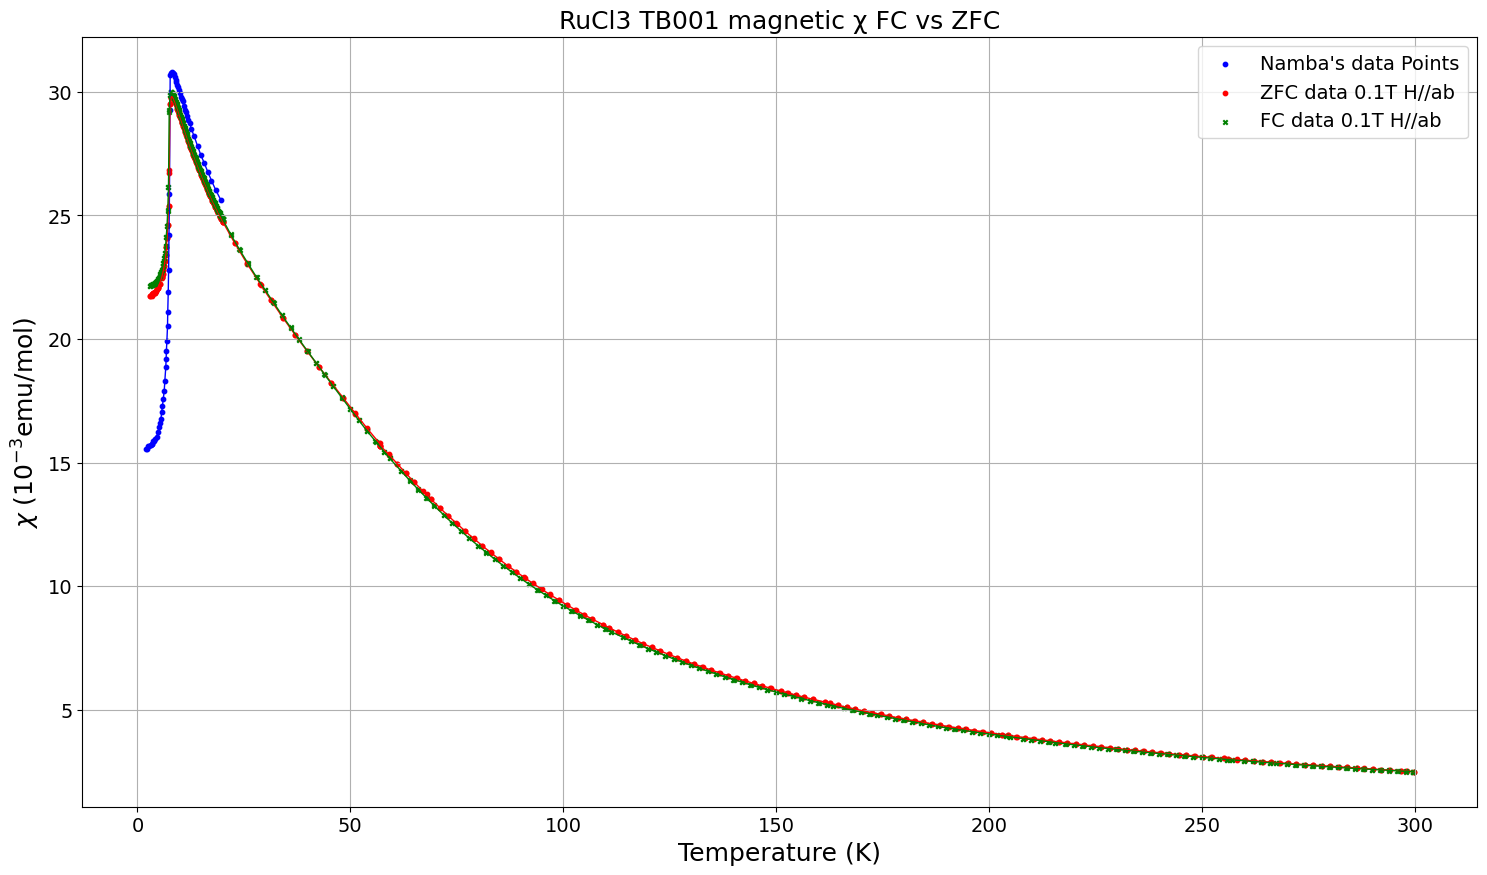

In [14]:
#SUSCEPTIBILITY OF RUCL3
#plot_mom_vs_temp(df_temperature_range, sample, field, fc_or_zfc)


#Namba paperData
#df_ref = pd.read_csv("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/magnetisation/Namba_raw_data.csv", sep=",", encoding='unicode_escape')
df_ref = pd.read_csv("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Magnetisation/Namba_raw_data.csv", sep=",", encoding='unicode_escape')

x = df_ref.loc[:,'x']
y = df_ref.loc[:,' y']
#namba paper data is in emu/mol so to convert ours we must multiply our data by a conversion factor to get the units as emu/mol
x1 = x
y1 = y*1000#to put as 10^-3

#our data
sample_mass=0.033 #in g
molar_mass = 207.43 #in g/mol
field = 1000 #in oe
conversion_factor = molar_mass/(field*sample_mass)
print(conversion_factor)

df_mag1, header_line = load_magnetisation_data(
    file_location=FILEANDPATHMag1,
    cgs_or_si="cgs",
    temp_range=(2, 300)
)
df_magFC, header_line = load_magnetisation_data(
    file_location=FILEANDPATHMag2,
    cgs_or_si="cgs",
    temp_range=(2, 300)
)


x2 = df_mag1.loc[:,'Temperature (K)']
y2 = df_mag1.loc[:,'Moment (emu)']
x2 = x2
y2 = y2*conversion_factor*1000#to put as 10^-3

x3 = df_magFC.loc[:,'Temperature (K)']
y3 = df_magFC.loc[:,'Moment (emu)']
x3 = x3
y3 = y3*conversion_factor*1000#to put as 10^-3

fig = figure(figsize=(18,10))



import numpy as np

def interp_ignore_nans(x, y):
    """Return x_sorted, y_interp with NaNs bridged linearly.
    Works with unsorted x, NaNs, and duplicate x."""
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    # sort by x
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]

    # keep only finite pairs to build the interpolant
    m = np.isfinite(x_sorted) & np.isfinite(y_sorted)
    if m.sum() < 2:
        # not enough points to interpolate; just return sorted inputs
        return x_sorted, y_sorted

    xs = x_sorted[m]
    ys = y_sorted[m]

    # collapse duplicate xs by averaging their y values
    uniq_xs, inv = np.unique(xs, return_inverse=True)
    ys_sum = np.zeros_like(uniq_xs, dtype=float)
    counts = np.zeros_like(uniq_xs, dtype=float)
    np.add.at(ys_sum, inv, ys)
    np.add.at(counts, inv, 1.0)
    ys_mean = ys_sum / counts

    # linear interpolation across the full x range (bridges NaNs)
    y_interp = np.interp(x_sorted, uniq_xs, ys_mean)

    return x_sorted, y_interp


# Build continuous lines
x1s, y1i = interp_ignore_nans(x1, y1)
x2s, y2i = interp_ignore_nans(x2, y2)
x3s, y3i = interp_ignore_nans(x3, y3)

# Plot points
plt.scatter(x1, y1, s=10, facecolors='b', edgecolors='b', label="Namba's data Points")
plt.scatter(x2, y2, s=10, facecolors='r', edgecolors='r', label="ZFC data 0.1T H//ab")
plt.scatter(x3, y3, s=10, facecolors='g', edgecolors='g', marker='x', label="FC data 0.1T H//ab")

# Plot interpolated connecting lines (will continue over NaNs)
plt.plot(x1s, y1i, color='b', linewidth=1)
plt.plot(x2s, y2i, color='r', linewidth=1)
plt.plot(x3s, y3i, color='g', linewidth=1)







#plt.xlim(0, 20)
#plt.ylim(bottom = 15)
#plt.ylim(3,8)
Title= 'RuCl3 TB001 magnetic χ FC vs ZFC'
plt.title(Title)
#plt.title('RuCl3 Batch TB001 magnetic χ data 05/02/2025')
plt.xlabel('Temperature (K)')
plt.ylabel(r'$\chi$ ($10^{-3}$emu/mol)')
plt.grid('both')
plt.legend()
save_next_plot("C:/Users/TXB909/Documents/strain-cell/Plotted Figures", prefix=Title)
#must save plot before plt.show() to ensure it saves the current figure
plt.show()

plt.close()   # optional: close the figure so the next one starts fresh




In [15]:
'Samp HC (J/mole-K)'

import pandas as pd
import os

'''
#Namba paperData
df_ref = pd.read_csv("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Namba_data_HC.csv", sep=",", encoding='unicode_escape')
x = df_ref.loc[:,'x']
y = df_ref.loc[:,' y']

x1 = x
y1 = y
'''

#our data

sample_mass=0.033 #in g
molar_mass = 207.43 #in g/mol

#9T HC

HC_9T_RuCl3 = HC_PPMS_data_loading("C:/Users/thoma/Documents/Physics_Work/Python Scripts/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Heat Capacity/07-04-2025_RuCl3_TB001_9T_ZFCW_coarse_Scan_15-300K_001.csv")
#HC_9T_RuCl3 = HC_PPMS_data_loading("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Heat Capacity/RuCl3_TB001_HC_9T_06-04-2025.csv")
HC_9T_RuCl3.sort_values(by=['Sample Temp (Kelvin)'])
x1 = HC_9T_RuCl3.loc[:,'Sample Temp (Kelvin)']
y1 = HC_9T_RuCl3.loc[:,'Samp HC (J/mole-K)']
y1err=HC_9T_RuCl3['Samp HC Err (J/mole-K)']

y2 = HC_9T_RuCl3.loc[:,'Sample Coupling (Percent)']




#get Specific heat capacity = C/T

y1 = y1/x1

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(14)
ax = fig.add_subplot(111)



ax.scatter(x1, y1, marker='x', s=50, 
                #c='r', 
                facecolors='b', edgecolors= 'b', label = '9T RuCl3 Heat Capacity')

#plt.errorbar(x2, y2, yerr=y2err,capsize=4,                    # little cap on the error bar
#    ecolor='gray',                # color of error bars
#    elinewidth=1.2,
#    markerfacecolor='blue')

ax.plot(x1, y1, c='b', linewidth=0.8)

ax2 = ax.twinx()

ax2.scatter(x1, y2, marker='o', s=50, 
                #c='r', 
                facecolors='r', edgecolors= 'r', label = 'Sample Coupling')

#plt.errorbar(x2, y2, yerr=y2err,capsize=4,                    # little cap on the error bar
#    ecolor='gray',                # color of error bars
#    elinewidth=1.2,
#    markerfacecolor='blue')

ax2.plot(x1, y2, c='r', linewidth=0.8)


plt.xlim(0, 310)
plt.title('RuCl3 TB001 H.C.')

plt.grid('both')
ax.set_xlabel('Sample Temperature (K)')
ax.set_ylabel('C/T (J/mole-K^2)')
ax2.set_ylabel('Sample Coupling (%)')
ax2.legend(loc=0)
ax.legend(loc=2)

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/thoma/Documents/Physics_Work/Python Scripts/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Heat Capacity/07-04-2025_RuCl3_TB001_9T_ZFCW_coarse_Scan_15-300K_001.csv'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from your specified file path
file_path = "C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/red_curve_C_over_T_vs_T.csv"
df = pd.read_csv(file_path)

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(df["Temperature (K)"], df["C_over_T (J/mol K^2)"], 'o', color='red', markersize=3, label='Red Curve')
# Load the data from your specified file path
file_path = "C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/red_curve_C_over_T_vs_T_final.csv"
df = pd.read_csv(file_path)

# Plot the data

plt.plot(df["Temperature (K)"], df["C_over_T (J/mol K^2)"], 'o', color='b', markersize=3, label='Namba\'s data Points')
###

# Labels and title
plt.xlabel("Temperature (K)")
plt.ylabel(r"$C/T$ (J mol$^{-1}$ K$^{-2}$)")
plt.title(r"Heat Capacity over Temperature vs Temperature")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
'''OLD CODE THAT I AM UNSURE IF TO KEEP OR NOT, BACKUP'''

#Namba paperData
#df_ref = pd.read_csv("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/magnetisation/Namba_raw_data.csv", sep=",", encoding='unicode_escape')
df_ref = pd.read_csv("C:/Users/TXB909/Documents/strain-cell/PPMS_Data_and_Plotting/Data/RuCl3/Data/Magnetisation/Namba_raw_data.csv", sep=",", encoding='unicode_escape')

x = df_ref.loc[:,'x']
y = df_ref.loc[:,' y']
#namba paper data is in emu/mol so to convert ours we must multiply our data by a conversion factor to get the units as emu/mol
x1 = x
y1 = y*1000#to put as 10^-3

#our data
sample_mass=0.033 #in g
molar_mass = 207.43 #in g/mol
field = 1000 #in oe
conversion_factor = molar_mass/(field*sample_mass)
print(conversion_factor)

df_mag1, header_line = load_magnetisation_data(
    file_location=FILEANDPATHMag1,
    cgs_or_si="cgs",
    temp_range=(2, 300)
)
df_magFC, header_line = load_magnetisation_data(
    file_location=FILEANDPATHMag2,
    cgs_or_si="cgs",
    temp_range=(2, 300)
)


x2 = df_mag1.loc[:,'Temperature (K)']
y2 = df_mag1.loc[:,'Moment (emu)']
x2 = x2
y2 = y2*conversion_factor*1000#to put as 10^-3

x3 = df_magFC.loc[:,'Temperature (K)']
y3 = df_magFC.loc[:,'Moment (emu)']
x3 = x3
y3 = y3*conversion_factor*1000#to put as 10^-3

fig = figure(figsize=(18,10))



import numpy as np

def interp_ignore_nans(x, y):
    """Return x_sorted, y_interp with NaNs bridged linearly.
    Works with unsorted x, NaNs, and duplicate x."""
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    # sort by x
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]

    # keep only finite pairs to build the interpolant
    m = np.isfinite(x_sorted) & np.isfinite(y_sorted)
    if m.sum() < 2:
        # not enough points to interpolate; just return sorted inputs
        return x_sorted, y_sorted

    xs = x_sorted[m]
    ys = y_sorted[m]

    # collapse duplicate xs by averaging their y values
    uniq_xs, inv = np.unique(xs, return_inverse=True)
    ys_sum = np.zeros_like(uniq_xs, dtype=float)
    counts = np.zeros_like(uniq_xs, dtype=float)
    np.add.at(ys_sum, inv, ys)
    np.add.at(counts, inv, 1.0)
    ys_mean = ys_sum / counts

    # linear interpolation across the full x range (bridges NaNs)
    y_interp = np.interp(x_sorted, uniq_xs, ys_mean)

    return x_sorted, y_interp


# Build continuous lines
x1s, y1i = interp_ignore_nans(x1, y1)
x2s, y2i = interp_ignore_nans(x2, y2)
x3s, y3i = interp_ignore_nans(x3, y3)

# Plot points
plt.scatter(x1, y1, s=10, facecolors='b', edgecolors='b', label="Namba's data Points")
plt.scatter(x2, y2, s=10, facecolors='r', edgecolors='r', label="ZFC data 0.1T H//ab")
plt.scatter(x3, y3, s=10, facecolors='g', edgecolors='g', marker='x', label="FC data 0.1T H//ab")

# Plot interpolated connecting lines (will continue over NaNs)
plt.plot(x1s, y1i, color='b', linewidth=1)
plt.plot(x2s, y2i, color='r', linewidth=1)
plt.plot(x3s, y3i, color='g', linewidth=1)







#plt.xlim(0, 20)
#plt.ylim(bottom = 15)
#plt.ylim(3,8)
Title= 'RuCl3 TB001 magnetic χ FC vs ZFC'
plt.title(Title)
#plt.title('RuCl3 Batch TB001 magnetic χ data 05/02/2025')
plt.xlabel('Temperature (K)')
plt.ylabel(r'$\chi$ ($10^{-3}$emu/mol)')
plt.grid('both')
plt.legend()
save_next_plot("C:/Users/TXB909/Documents/strain-cell/Plotted Figures", prefix=Title)
#must save plot before plt.show() to ensure it saves the current figure
plt.show()

plt.close()   # optional: close the figure so the next one starts fresh


